In [1]:
import pygmt
import pandas as pd
import numpy as np
import scipy
from scipy.spatial import cKDTree
from matplotlib.path import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import xarray as xr
import verde as vd
# For projecting data
import pyproj
# For fetching sample datasets
import ensaio
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LogNorm, PowerNorm
from datetime import date
import multiprocessing, os, sys, getopt, time

In [2]:
#path_to_data_file = ensaio.fetch_alps_gps(version=1)
#print(path_to_data_file)
#path_to_data_file = "/home/amitava/Geodynamics-Project-IISERP/India_Tibet/RF_India/Ind_RF.csv" ## For Ubuntu
path_to_data_file = r"D:\Amitava_Laptop\Geodynamics-Project-IISERP\India_Tibet\Global_crust.csv" ## For windos OR use '\\' instead of '\'#data_eq_raw = pd.read_csv(path_to_data_file, comment='#', delim_whitespace=True)
data_eq_raw = pd.read_csv(path_to_data_file, comment='#') # data_eq_raw = pd.read_csv(path_to_data_file, comment='#', delimiter=',')  ## No delimeter is defaulted as comma

########################
'''
## Read the file to find the header line
with open(path_to_data_file, 'r') as f:
    for line in f:
        if line.startswith('#'):
            header = line.strip('#').strip().split()  # Remove '#' and split into column names
            break
########################
'''
# Convert Moho_km to numeric, forcing non-numeric values to NaN
data_eq_raw["Moho_km"] = pd.to_numeric(data_eq_raw["Moho_km"], errors="coerce")

# Drop rows with NaN values in Moho_km
data_eq_all = data_eq_raw.dropna(subset=["Moho_km"])

# df = df.reset_index(drop=True) # To reset index
data_eq_all = data_eq_all.reset_index(drop=True)


# Filter data based on longitude and latitude
data_eq_ind = data_eq_all[
    (data_eq_all["Long"] >= 65) & (data_eq_all["Long"] <= 110) & 
    (data_eq_all["Lat"] >= 5) & (data_eq_all["Lat"] <= 45)
].reset_index(drop=True)

data_eq = data_eq_ind

# Display the data

eq_info = data_eq
data_eq
#data_eq.to_csv("eq_data.csv", index=False)

C:\Users\DELL\AppData\Local\Temp\ipykernel_22612\2748220165.py:5: DtypeWarning: Columns (0,1,4,5,6,7,8,12,13,14,18,19,20,22) have mixed types. Specify dtype option on import or set low_memory=False.
  data_eq_raw = pd.read_csv(path_to_data_file, comment='#') # data_eq_raw = pd.read_csv(path_to_data_file, comment='#', delimiter=',')  ## No delimeter is defaulted as comma


Net Station    Lat    Long  Moho_km err_moho Avg_Vp/Vs Poisson’s_ratio  \
0     NaN     A01  36.43   94.87     49.5      NaN      1.78            0.27   
1     NaN     A01  36.43   94.87     48.0      NaN      1.81            0.28   
2     NaN     A03  36.81   92.95     49.0      NaN      1.78           0.269   
3     NaN     A05  37.02   91.74     57.0      NaN      1.83           0.287   
4     NaN    AMDO  32.25   91.70     74.0      NaN      1.73           0.249   
...   ...     ...    ...     ...      ...      ...       ...             ...   
8298  NaN     NaN  21.33  103.91     34.0      NaN      1.79             NaN   
8299  NaN     NaN  17.42   78.55     33.0      NaN      1.74             NaN   
8300  NaN     NaN   8.28   73.06     14.0      NaN       1.6             NaN   
8301  NaN     NaN  11.66   92.74     19.0      NaN      1.97             NaN   
8302  NaN     NaN   7.27   80.70     40.0      NaN      1.66             NaN   

     Elevation  Avg_Vp(km/s)  ...    Reference  \
0          NaN          6.20  ...           Xu   
1          NaN          6.22  ...          Yue   
2          NaN          6.20  ...          Yue   
3          NaN          6.38  ...          Yue   
4          NaN          6.20  ...  Sherrington   
...        ...           ...  ...          ...   
8298       NaN           NaN  ...         EARS   
8299       NaN           NaN  ...         EARS   
8300       NaN           NaN  ...         EARS   
8301       NaN           NaN  ...         EARS   
8302       NaN           NaN  ...         EARS   

      Comments (Method - other notes etc.) Sub-methods Comments2  \
0                                      NaN         NaN       NaN   
1                                      NaN         NaN       NaN   
2                                      NaN         NaN       NaN   
3                                      NaN         NaN       NaN   
4                                      NaN         NaN       NaN   
...                                    ...         ...       ...   
8298                                    Hk         NaN       NaN   
8299                                    Hk         NaN       NaN   
8300                                    Hk         NaN       NaN   
8301                                    Hk         NaN       NaN   
8302                                    Hk         NaN       NaN   

     H2 (other methods) err Vsn2  κ2 Unnamed: 24 Unnamed: 25  
0                   NaN NaN  NaN NaN         NaN         NaN  
1                   NaN NaN  NaN NaN         NaN         NaN  
2                   NaN NaN  NaN NaN         NaN         NaN  
3                   NaN NaN  NaN NaN         NaN         NaN  
4                   NaN NaN  NaN NaN         NaN         NaN  
...                 ...  ..  ...  ..         ...         ...  
8298                NaN NaN  NaN NaN         NaN         NaN  
8299                NaN NaN  NaN NaN         NaN         NaN  
8300                NaN NaN  NaN NaN         NaN         NaN  
8301                NaN NaN  NaN NaN         NaN         NaN  
8302                NaN NaN  NaN NaN         NaN         NaN  

[8303 rows x 26 columns]

In [3]:
data_eq_ind

Net Station    Lat    Long  Moho_km err_moho Avg_Vp/Vs Poisson’s_ratio  \
0     NaN     A01  36.43   94.87     49.5      NaN      1.78            0.27   
1     NaN     A01  36.43   94.87     48.0      NaN      1.81            0.28   
2     NaN     A03  36.81   92.95     49.0      NaN      1.78           0.269   
3     NaN     A05  37.02   91.74     57.0      NaN      1.83           0.287   
4     NaN    AMDO  32.25   91.70     74.0      NaN      1.73           0.249   
...   ...     ...    ...     ...      ...      ...       ...             ...   
8298  NaN     NaN  21.33  103.91     34.0      NaN      1.79             NaN   
8299  NaN     NaN  17.42   78.55     33.0      NaN      1.74             NaN   
8300  NaN     NaN   8.28   73.06     14.0      NaN       1.6             NaN   
8301  NaN     NaN  11.66   92.74     19.0      NaN      1.97             NaN   
8302  NaN     NaN   7.27   80.70     40.0      NaN      1.66             NaN   

     Elevation  Avg_Vp(km/s)  ...    Reference  \
0          NaN          6.20  ...           Xu   
1          NaN          6.22  ...          Yue   
2          NaN          6.20  ...          Yue   
3          NaN          6.38  ...          Yue   
4          NaN          6.20  ...  Sherrington   
...        ...           ...  ...          ...   
8298       NaN           NaN  ...         EARS   
8299       NaN           NaN  ...         EARS   
8300       NaN           NaN  ...         EARS   
8301       NaN           NaN  ...         EARS   
8302       NaN           NaN  ...         EARS   

      Comments (Method - other notes etc.) Sub-methods Comments2  \
0                                      NaN         NaN       NaN   
1                                      NaN         NaN       NaN   
2                                      NaN         NaN       NaN   
3                                      NaN         NaN       NaN   
4                                      NaN         NaN       NaN   
...                                    ...         ...       ...   
8298                                    Hk         NaN       NaN   
8299                                    Hk         NaN       NaN   
8300                                    Hk         NaN       NaN   
8301                                    Hk         NaN       NaN   
8302                                    Hk         NaN       NaN   

     H2 (other methods) err Vsn2  κ2 Unnamed: 24 Unnamed: 25  
0                   NaN NaN  NaN NaN         NaN         NaN  
1                   NaN NaN  NaN NaN         NaN         NaN  
2                   NaN NaN  NaN NaN         NaN         NaN  
3                   NaN NaN  NaN NaN         NaN         NaN  
4                   NaN NaN  NaN NaN         NaN         NaN  
...                 ...  ..  ...  ..         ...         ...  
8298                NaN NaN  NaN NaN         NaN         NaN  
8299                NaN NaN  NaN NaN         NaN         NaN  
8300                NaN NaN  NaN NaN         NaN         NaN  
8301                NaN NaN  NaN NaN         NaN         NaN  
8302                NaN NaN  NaN NaN         NaN         NaN  

[8303 rows x 26 columns]

In [4]:
# Count lines starting with '#'
num_commented_lines = sum(1 for line in open(path_to_data_file, 'r') if line.startswith('#'))

# Count NaN values in Moho_km
num_nans = data_eq_raw["Moho_km"].isna().sum()

print(f"Number of lines ignored due to comments: {num_commented_lines}")
print(f"Number of NaN values in Moho_km: {num_nans}")


Number of lines ignored due to comments: 39
Number of NaN values in Moho_km: 44


In [5]:
#region = [25, 110, 5, 45]
#region = [-180, 180, -90, 90]  # Covers the whole world
region = [-180, 180, -80, 80] #avoids the poles
print(region)

[-180, 180, -80, 80]


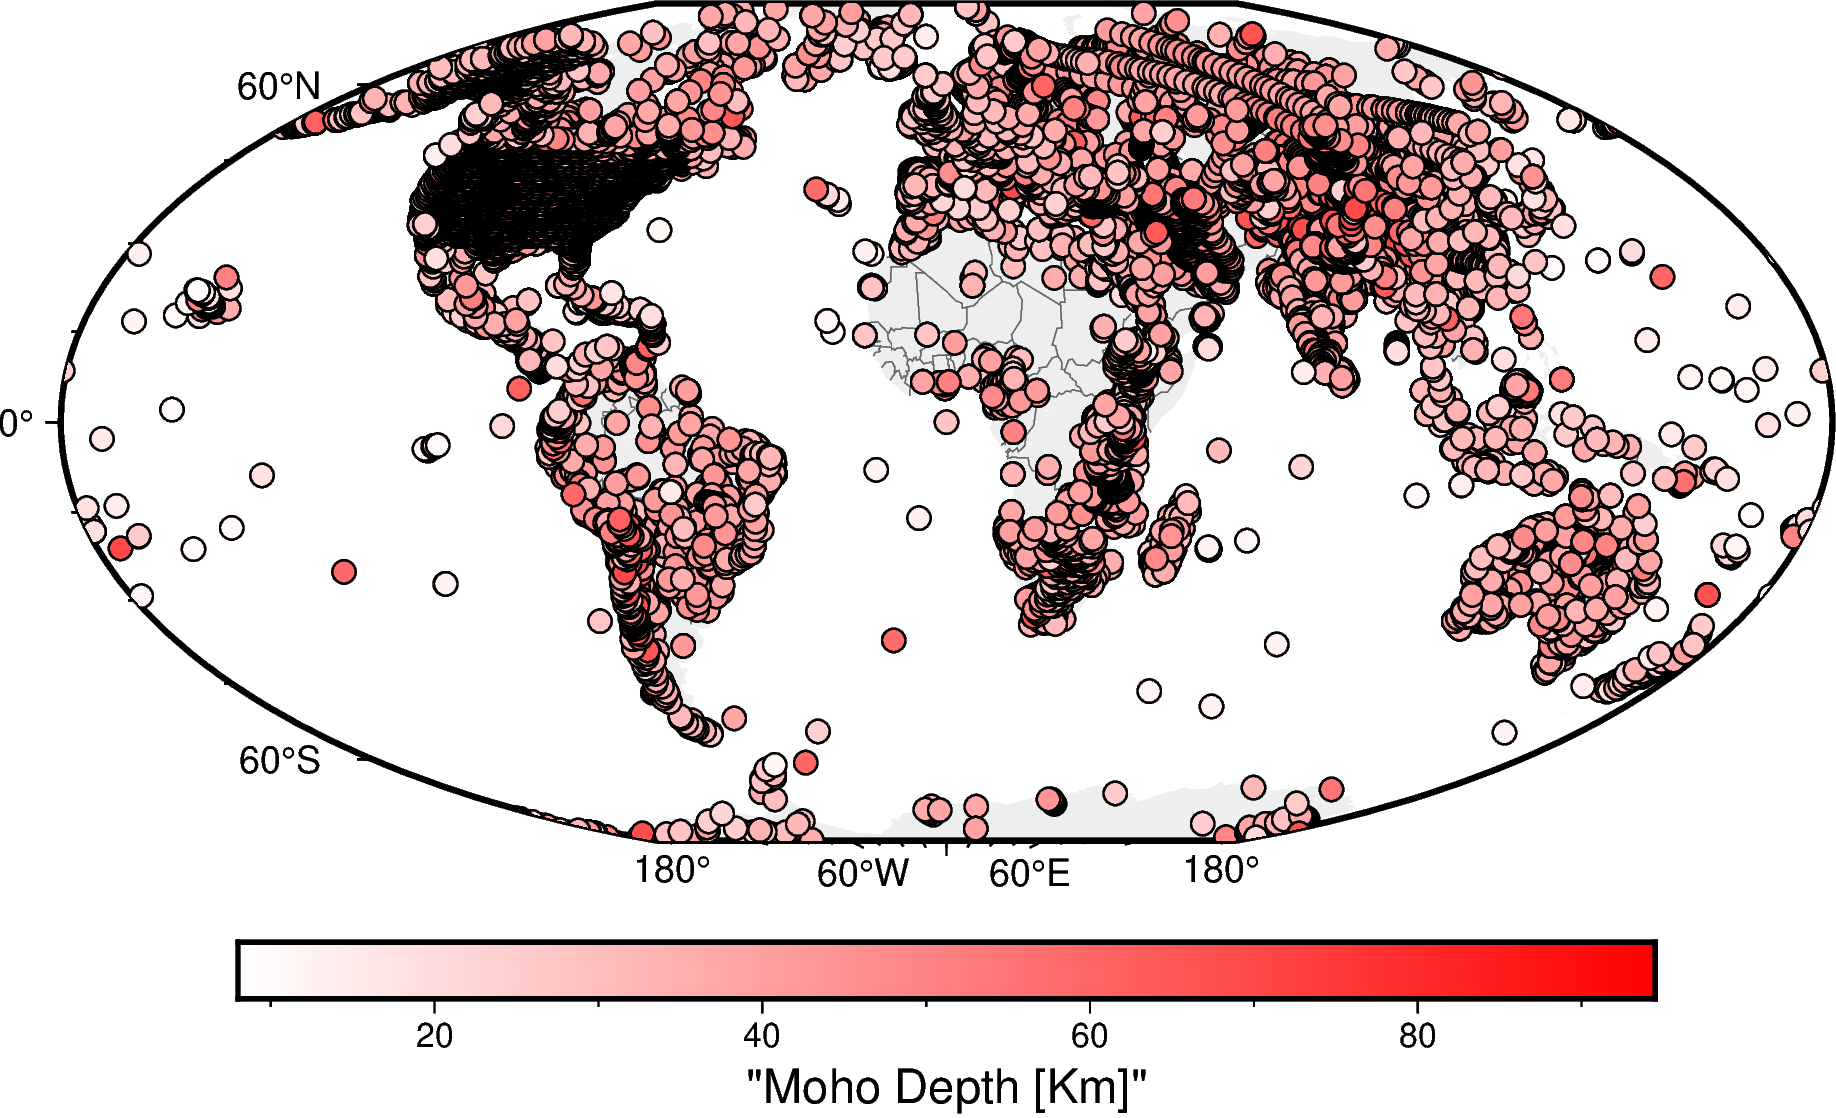

In [6]:
# Start a figure
fig = pygmt.Figure()
# Add a basemap with the data region, Mercator projection, default frame
# and ticks, color in the continents, and display national borders
fig.coast(
    region=region, projection="W15c", frame="af",
    land="#eeeeee", borders="1/#666666", area_thresh=1e4,
)
# Create a colormap for the Moho Depth
pygmt.makecpt(
    cmap="polar+h",
    series=[data_eq_all.Moho_km.min(), data_eq_all.Moho_km.max()],
    #series = [data.iloc[:, 5].min(), data.iloc[:, 5].max()],
)
# Plot colored points for the velocities
fig.plot(
    x=data_eq_all.Long,
    y=data_eq_all.Lat,
    fill=data_eq_all.Moho_km,
    style="c0.2c",
    cmap=True,
    pen="0.5p,black",
)
# Add a colorbar with automatic frame and ticks and a label
fig.colorbar(frame='af+l"Moho Depth [Km]"')
fig.show()


# Test: Ensaio & Earth Topography

In [7]:
topography = ensaio.fetch_earth_topography(version=1)
#topography = "/home/amitava/Geodynamics-Project-IISERP/India_Tibet/5930767/Crustal_thickness.nc"  #for custom topography
data_topo = xr.load_dataarray(topography)
data_topo

<xarray.DataArray 'topography' (latitude: 1081, longitude: 2161)> Size: 19MB
array([[ 2742.,  2742.,  2742., ...,  2742.,  2742.,  2742.],
       [ 2768.,  2768.,  2768., ...,  2768.,  2768.,  2768.],
       [ 2822.,  2822.,  2821., ...,  2822.,  2822.,  2822.],
       ...,
       [-4243., -4244., -4245., ..., -4242., -4243., -4243.],
       [-4156., -4157., -4157., ..., -4156., -4156., -4156.],
       [-4237., -4237., -4237., ..., -4237., -4237., -4237.]])
Coordinates:
  * longitude  (longitude) float64 17kB -180.0 -179.8 -179.7 ... 179.8 180.0
  * latitude   (latitude) float64 9kB -90.0 -89.83 -89.67 ... 89.67 89.83 90.0
Attributes:
    Conventions:     CF-1.8
    title:           Topographic and bathymetric height of ETOPO1 (ice surfac...
    crs:             WGS84
    source:          Generated from a spherical harmonic model by the ICGEM C...
    license:         public domain
    references:      https://doi.org/10.7289/V5C8276M
    long_name:       topographic height above mean sea level
    standard_name:   height_above_mean_sea_level
    description:     height topography/bathymetry referenced to mean sea level
    units:           m
    actual_range:    [-10023.   6082.]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

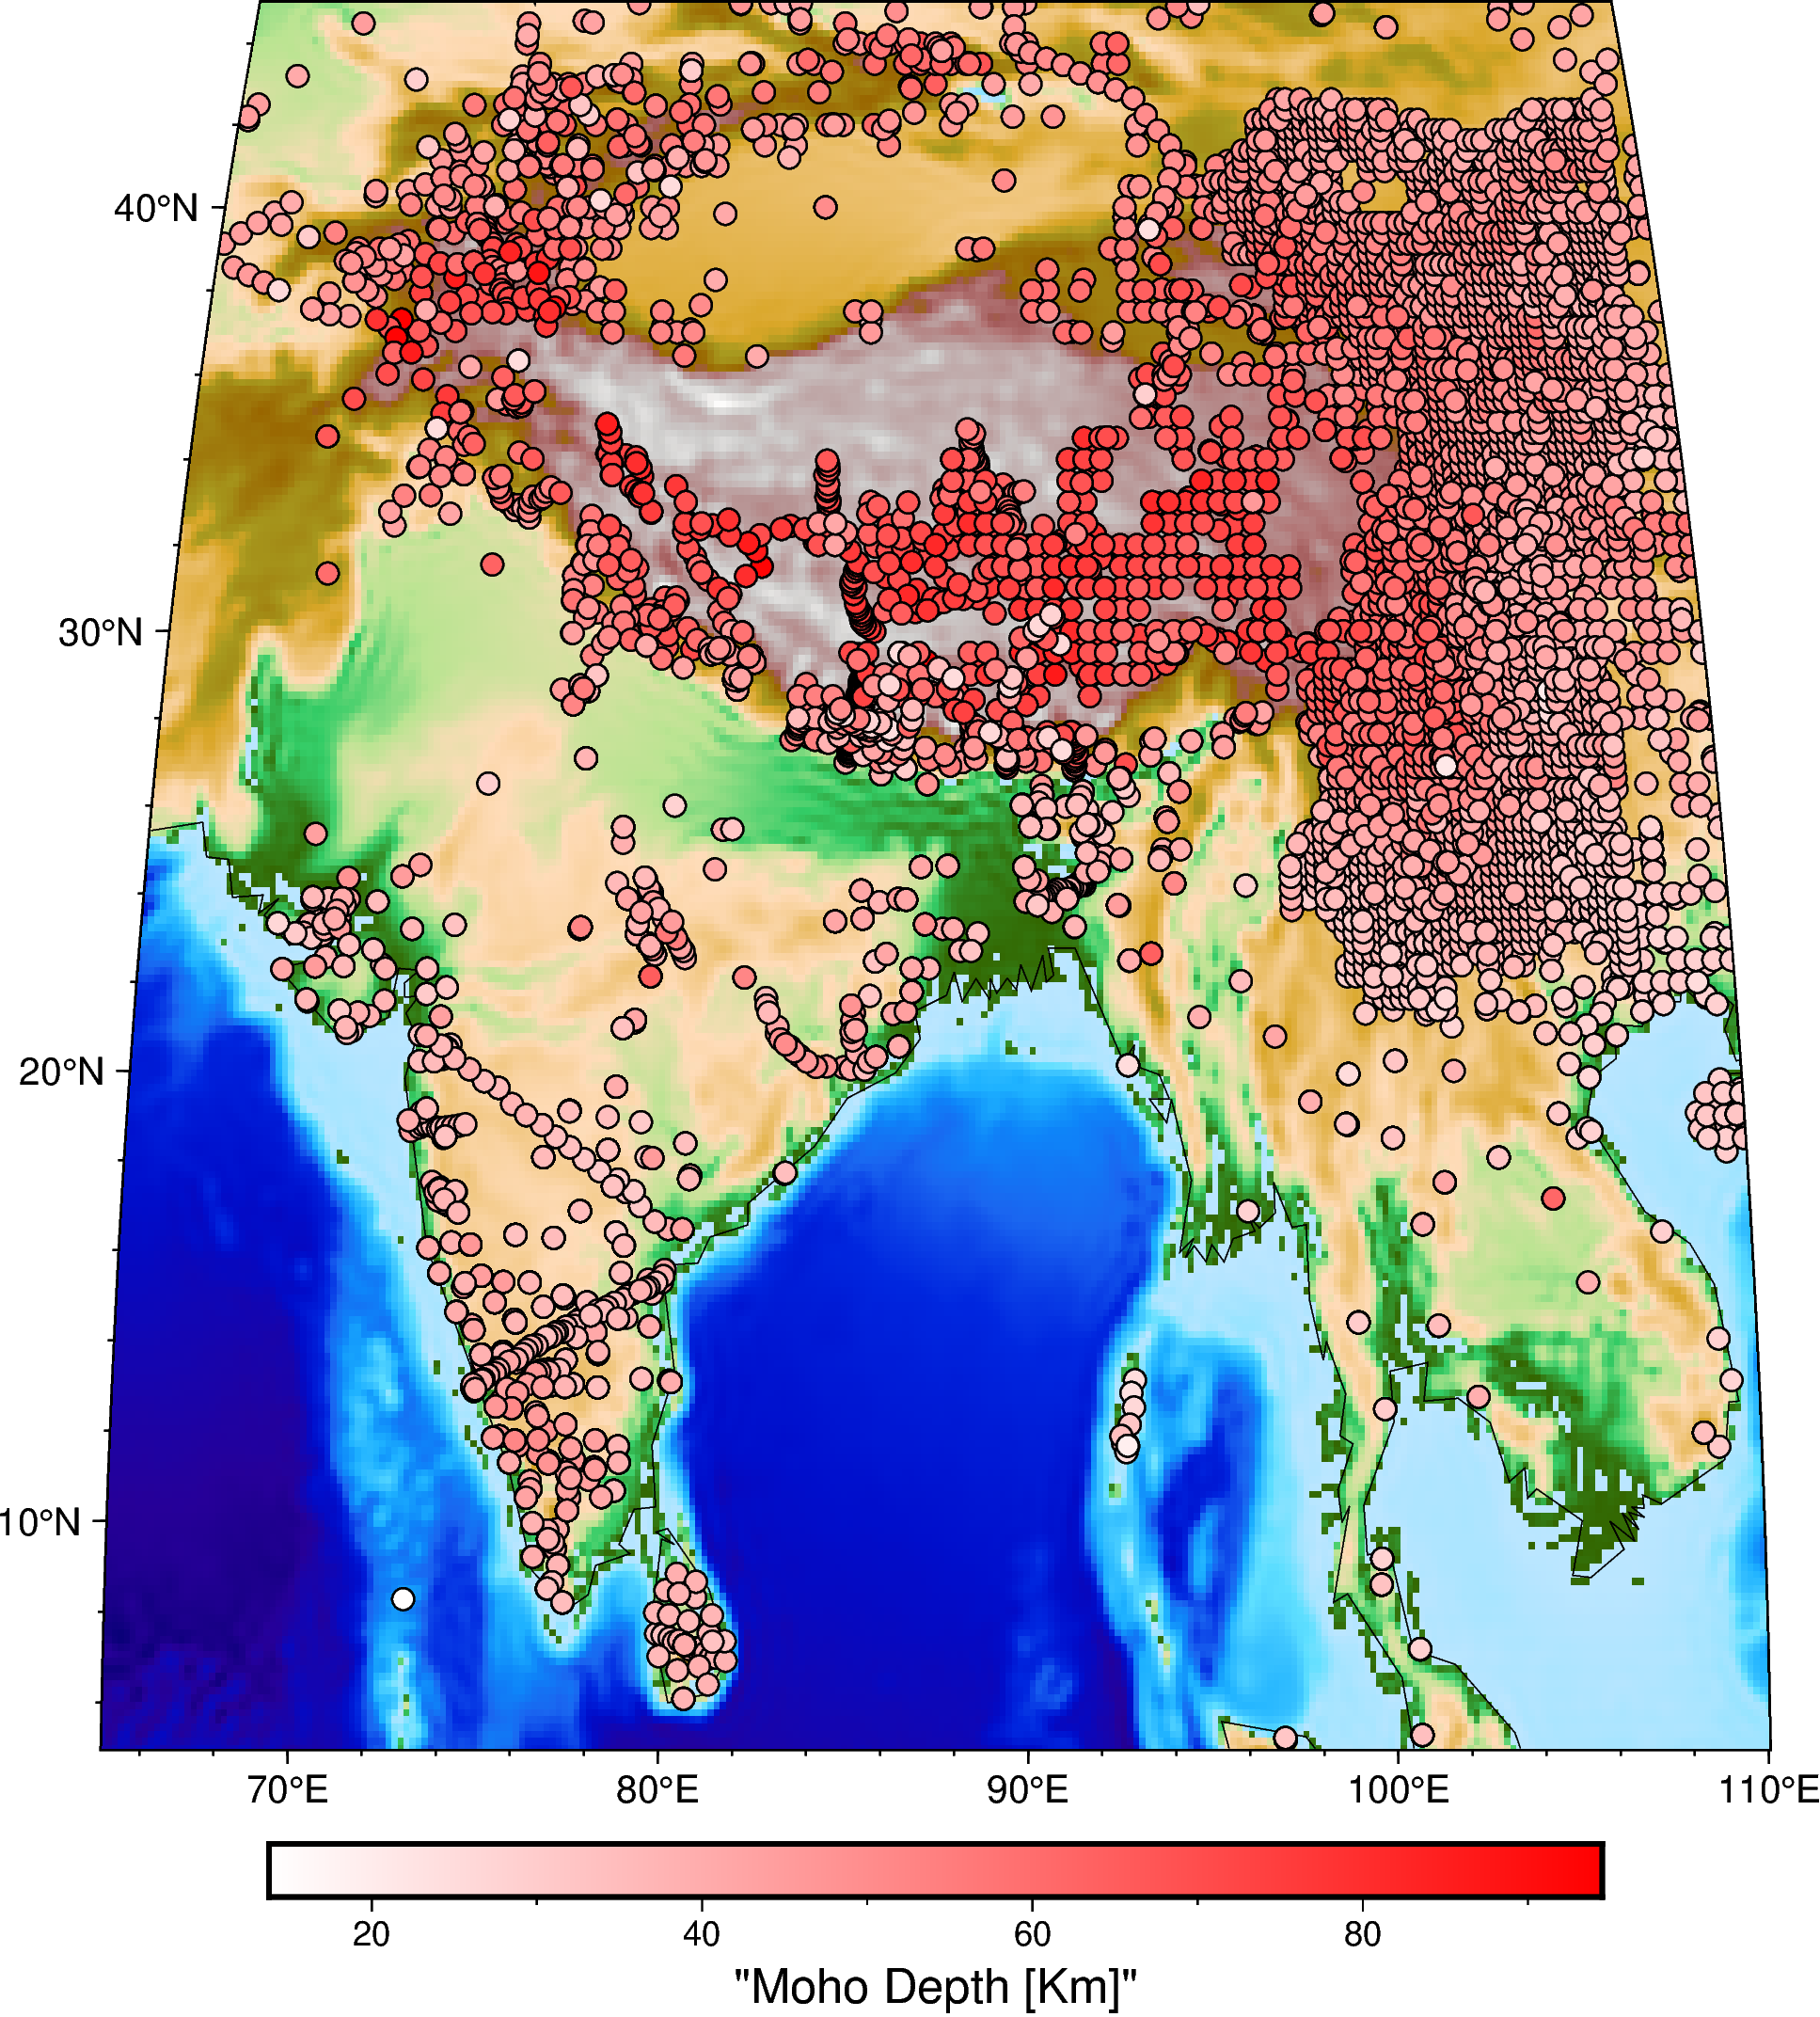

In [8]:
fig = pygmt.Figure()
fig.basemap(
    #region="g", # for the entire world
    region = [65, 110, 5, 45],
    projection="W15c",
    frame=True,
)
fig.grdimage(data_topo, cmap="etopo1", shading="+nt0.5")
#fig.colorbar(frame='af+l"topography [m]"')
fig.coast(shorelines=True, resolution="c", area_thresh=1e4)
# Create a colormap for the Moho Depth
pygmt.makecpt(
    cmap="polar+h",
    series=[data_eq.Moho_km.min(), data_eq.Moho_km.max()],
    #series = [data.iloc[:, 5].min(), data.iloc[:, 5].max()],
)
# Plot colored points for the velocities
fig.plot(
    x=data_eq.Long,
    y=data_eq.Lat,
    fill=data_eq.Moho_km,
    style="c0.2c",
    cmap=True,
    pen="0.5p,black",
)
# Add a colorbar with automatic frame and ticks and a label
fig.colorbar(frame='af+l"Moho Depth [Km]"')
fig.show()
#fig.savefig("/home/amitava/Geodynamics-Project-IISERP/India_Tibet/RF_India/moho_depth_map.png", dpi=300)

# Load Crust1.0

In [9]:
#path_to_data_file_moho = "/home/amitava/Geodynamics-Project-IISERP/tomo/crust_ind.csv" ## for Ubuntu
path_to_data_file_moho = r"D:\Amitava_Laptop\Geodynamics-Project-IISERP\tomo\crust.csv"
#path_to_data_file_moho = "/home/amitava/Geodynamics-Project-IISERP/India_Tibet/RF_India/Crustal_thickness.csv"
#path_to_data_file = "/home/amitava/Geodynamics-Project-IISERP/India_Tibet/RF_India/TEC26522-mmc2_aug.csv"

# Read the file again with the extracted header
data_raw = pd.read_csv(path_to_data_file_moho, delim_whitespace=True)

# Apply the filtering criteria
data_moho_ind = data_raw[
    (data_raw["longitude"] >= 65) & (data_raw["longitude"] <= 110) & 
    (data_raw["latitude"] >= 5) & (data_raw["latitude"] <= 45)
].reset_index(drop=True)

#data_moho = data_raw.dropna()
data_moho = data_moho_ind.dropna()
#print(data.head())
crust1_moho = data_moho
#print (crust1_moho)
data_moho

C:\Users\DELL\AppData\Local\Temp\ipykernel_22612\262122288.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data_raw = pd.read_csv(path_to_data_file_moho, delim_whitespace=True)


longitude  latitude   Moho
0          65.5      44.5  38.31
1          66.5      44.5  39.22
2          67.5      44.5  40.41
3          68.5      44.5  41.65
4          69.5      44.5  42.31
...         ...       ...    ...
1795      105.5       5.5  29.93
1796      106.5       5.5  29.93
1797      107.5       5.5  29.93
1798      108.5       5.5  29.90
1799      109.5       5.5  28.87

[1800 rows x 3 columns]

# Ensure numeric types for latitude and longitude

In [10]:
data_moho["longitude"] = pd.to_numeric(data_moho["longitude"], errors="coerce")
data_moho["latitude"] = pd.to_numeric(data_moho["latitude"], errors="coerce")
data_eq["Long"] = pd.to_numeric(data_eq["Long"], errors="coerce")
data_eq["Lat"] = pd.to_numeric(data_eq["Lat"], errors="coerce")

# Plotting Different Tests

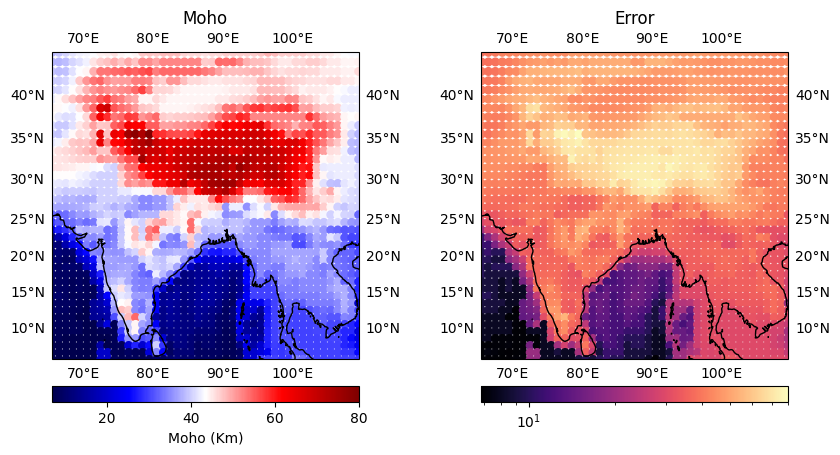

In [16]:
def plot_data(coordinates, moho, weights, title_data, title_weights):
    "Make two maps of our data, one with the data and one with the weights"
    fig, axes = plt.subplots(
        1, 2, figsize=(9.5, 7), subplot_kw=dict(projection=ccrs.Mercator())
    )
    fig.subplots_adjust(wspace=0.4)  # Increase space (default is 0.2)
    
    region = [
        data_moho.longitude.min(), data_moho.longitude.max(), 
        data_moho.latitude.min(), data_moho.latitude.max()
    ]
    
    #region = [65, 110, 5, 45]
    # Setting up the map projection
    crs = ccrs.PlateCarree()  # Using PlateCarree for the base map
    
    for ax in axes:
        ax.set_extent(region, crs=crs)  # Set region for both subplots
        ax.coastlines()  # Add coastlines
        #ax.add_feature(cfeature.BORDERS, linestyle=':')  # Add national boundaries
        gl = ax.gridlines(draw_labels=True, crs=crs, alpha=0)
        #gl.xlabels_top = False
        #gl.ylabels_left = False
        
                               
    # Plotting the data (first subplot)
    ax = axes[0]
    ax.set_title(title_data)
    maxabs = np.nanmax(np.abs(moho))  
    minabs = np.nanmin(np.abs(moho))
    pc = ax.scatter(
        *coordinates,
        c=moho,
        s=30,
        cmap="seismic",
        vmin=minabs,
        vmax=maxabs,
        transform=crs,
    )
    plt.colorbar(pc, ax=ax, orientation="horizontal", pad=0.05).set_label("Moho (Km)")

    # Plotting the weights (second subplot)
    ax = axes[1]
    ax.set_title(title_weights)
    pc = ax.scatter(
        *coordinates,
        c=weights,
        s=30,
        cmap="magma",
        transform=crs,
        norm=LogNorm()
    )
    plt.colorbar(pc, ax=ax, orientation="horizontal", pad=0.05)
    
    plt.show()

# Assuming data_moho is a dataframe with latitude, longitude, Moho values, and weights.
plot_data(
    (data_moho.longitude, data_moho.latitude),
    data_moho.Moho,
    data_moho.Moho,  # Weights might be a different column, adjust accordingly
    "Moho",
    "Error"  # Increase space (default is 0.2)

)

# Spline Interpolation

In [12]:
data = data_eq
coordinates=(data.Long, data.Lat)
moho=data.Moho_km
data
#print (moho)

Net Station    Lat    Long  Moho_km err_moho Avg_Vp/Vs Poisson’s_ratio  \
0     NaN     A01  36.43   94.87     49.5      NaN      1.78            0.27   
1     NaN     A01  36.43   94.87     48.0      NaN      1.81            0.28   
2     NaN     A03  36.81   92.95     49.0      NaN      1.78           0.269   
3     NaN     A05  37.02   91.74     57.0      NaN      1.83           0.287   
4     NaN    AMDO  32.25   91.70     74.0      NaN      1.73           0.249   
...   ...     ...    ...     ...      ...      ...       ...             ...   
8298  NaN     NaN  21.33  103.91     34.0      NaN      1.79             NaN   
8299  NaN     NaN  17.42   78.55     33.0      NaN      1.74             NaN   
8300  NaN     NaN   8.28   73.06     14.0      NaN       1.6             NaN   
8301  NaN     NaN  11.66   92.74     19.0      NaN      1.97             NaN   
8302  NaN     NaN   7.27   80.70     40.0      NaN      1.66             NaN   

     Elevation  Avg_Vp(km/s)  ...    Reference  \
0          NaN          6.20  ...           Xu   
1          NaN          6.22  ...          Yue   
2          NaN          6.20  ...          Yue   
3          NaN          6.38  ...          Yue   
4          NaN          6.20  ...  Sherrington   
...        ...           ...  ...          ...   
8298       NaN           NaN  ...         EARS   
8299       NaN           NaN  ...         EARS   
8300       NaN           NaN  ...         EARS   
8301       NaN           NaN  ...         EARS   
8302       NaN           NaN  ...         EARS   

      Comments (Method - other notes etc.) Sub-methods Comments2  \
0                                      NaN         NaN       NaN   
1                                      NaN         NaN       NaN   
2                                      NaN         NaN       NaN   
3                                      NaN         NaN       NaN   
4                                      NaN         NaN       NaN   
...                                    ...         ...       ...   
8298                                    Hk         NaN       NaN   
8299                                    Hk         NaN       NaN   
8300                                    Hk         NaN       NaN   
8301                                    Hk         NaN       NaN   
8302                                    Hk         NaN       NaN   

     H2 (other methods) err Vsn2  κ2 Unnamed: 24 Unnamed: 25  
0                   NaN NaN  NaN NaN         NaN         NaN  
1                   NaN NaN  NaN NaN         NaN         NaN  
2                   NaN NaN  NaN NaN         NaN         NaN  
3                   NaN NaN  NaN NaN         NaN         NaN  
4                   NaN NaN  NaN NaN         NaN         NaN  
...                 ...  ..  ...  ..         ...         ...  
8298                NaN NaN  NaN NaN         NaN         NaN  
8299                NaN NaN  NaN NaN         NaN         NaN  
8300                NaN NaN  NaN NaN         NaN         NaN  
8301                NaN NaN  NaN NaN         NaN         NaN  
8302                NaN NaN  NaN NaN         NaN         NaN  

[8303 rows x 26 columns]

# Projection, Coordinates, Region and Spacing

In [13]:
'''
coordinates = (data.Long.values, data.Lat.values)
region = vd.get_region(coordinates)

# Use a Mercator projection for our Cartesian gridder
projection = pyproj.Proj(proj="merc", lat_ts=data.Lat.mean())
print(region)
print(coordinates)

# The output grid spacing will 6 arc-minutes. If n/60 then x arc minutes
spacing = 6 / 60
'''

'\ncoordinates = (data.Long.values, data.Lat.values)\nregion = vd.get_region(coordinates)\n\n# Use a Mercator projection for our Cartesian gridder\nprojection = pyproj.Proj(proj="merc", lat_ts=data.Lat.mean())\nprint(region)\nprint(coordinates)\n\n# The output grid spacing will 6 arc-minutes. If n/60 then x arc minutes\nspacing = 6 / 60\n'

### Spline weighted

In [14]:
'''
# This spline will automatically perform cross-validation and search for the
# optimal parameter configuration.
#spline = vd.Spline(mindist=10e3)
#spline = vd.Spline(mindist=50e3, damping=1e-2)  # 50 km minimum correlation length
#spline = vd.SplineCV(dampings=(1e-5, 1e-3, 1e-1)) #std = 4.6
spline = vd.SplineCV(dampings=(1e-7, 1e-5, 1e-3, 1e-1))
#spline = vd.SplineCV()

# Fit the model on the data. Under the hood, the class will perform K-fold
# cross-validation for each the 3 parameter values and pick the one with the
# highest score.
spline.fit(projection(*coordinates), data.Moho_km)

# Spline Score and Dampings: Use only when usinge SplineCV otherwise comment the Score and Damping Prints
# We can show the best R² score obtained in the cross-validation
print("\nScore: {:.3f}".format(spline.scores_.max()))

# And then the best damping parameter that produced this high score.
print("\nBest damping:", spline.damping_)

# Now we can create a geographic grid of air temperature by providing a
# projection function to the grid method and mask points that are too far from
# the observations
grid_full = spline.grid(
    region=region,
    spacing=spacing,
    projection=projection,
    dims=["latitude", "longitude"],
    data_names="moho",
)
grid = vd.distance_mask(
    coordinates, maxdist=3 * spacing * 111e3, grid=grid_full, projection=projection
)
'''

'\n# This spline will automatically perform cross-validation and search for the\n# optimal parameter configuration.\n#spline = vd.Spline(mindist=10e3)\n#spline = vd.Spline(mindist=50e3, damping=1e-2)  # 50 km minimum correlation length\n#spline = vd.SplineCV(dampings=(1e-5, 1e-3, 1e-1)) #std = 4.6\nspline = vd.SplineCV(dampings=(1e-7, 1e-5, 1e-3, 1e-1))\n#spline = vd.SplineCV()\n\n# Fit the model on the data. Under the hood, the class will perform K-fold\n# cross-validation for each the 3 parameter values and pick the one with the\n# highest score.\nspline.fit(projection(*coordinates), data.Moho_km)\n\n# Spline Score and Dampings: Use only when usinge SplineCV otherwise comment the Score and Damping Prints\n# We can show the best R² score obtained in the cross-validation\nprint("\nScore: {:.3f}".format(spline.scores_.max()))\n\n# And then the best damping parameter that produced this high score.\nprint("\nBest damping:", spline.damping_)\n\n# Now we can create a geographic grid of air 

# Parallel Processing Spline and changing Mercator projection for Global data to Equal Earth Projection

In [ ]:
# Define regional bounding boxes (long_min, long_max, lat_min, lat_max)
regions = {
    "South_Asia_SE_Asia": [60, 130, -10, 40],
    "East_Asia": [100, 150, 20, 55],
    "Middle_East_Central_Asia": [30, 90, 20, 55],
    "North_Asia": [50, 180, 50, 85],
    "Oceania_SW_Pacific": [110, 180, -50, 10],
    "East_Europe": [10, 50, 40, 60],
    "West_Europe_North_Atlantic": [-30, 20, 40, 70],
    "NW_America_NE_Pacific": [-180, -100, 30, 80],
    "NE_America_North_Atlantic": [-100, -40, 30, 70],
    "SW_America_SE_Pacific": [-120, -60, -60, 30],
    "SE_America_South_Atlantic": [-60, 0, -60, 20],
    "Antarctica_Southern_Ocean": [-180, 180, -90, -50],
}

# Define projections
proj_in = pyproj.CRS("EPSG:4326")  # WGS84 Lat/Lon
proj_out = pyproj.CRS.from_proj4("+proj=wintri")  # Winkel Tripel (W15c)

# Transformer for reprojecting coordinates
transformer = pyproj.Transformer.from_crs(proj_in, proj_out, always_xy=True)

# Convert global dataset coordinates
x_proj, y_proj = transformer.transform(data.Long.values, data.Lat.values)
coordinates = (x_proj, y_proj)

# Define output grid spacing (6 arc-minutes = 0.1°). If n/60 then x arc minutes
spacing = 6 / 60

# Function to process each region
def process_region(region_name, bounds):
    """Fits a spline model and generates a grid for a specific region."""
    print(f"Processing region: {region_name}")  # Add this line

    lon_min, lon_max, lat_min, lat_max = bounds

    # Mask data points that fall within the region
    mask = (
        (data.Long >= lon_min) & (data.Long <= lon_max) &
        (data.Lat >= lat_min) & (data.Lat <= lat_max)
    )
    x_region, y_region = data.Long[mask].values, data.Lat[mask].values
    moho_region = data.Moho_km[mask].values

    if len(x_region) == 0:
        return None  # Skip empty regions

    # Reproject regional coordinates
    x_proj, y_proj = transformer.transform(x_region, y_region)

    # Fit SplineCV model with cross-validation
    spline = vd.SplineCV(dampings=(1e-7, 1e-5, 1e-3, 1e-1))
    spline.fit((x_proj, y_proj), moho_region)

    # Display the best R² score and damping for this region
    print(f"\nRegion: {region_name}")
    print("Score: {:.3f}".format(spline.scores_.max()))
    print("Best damping:", spline.damping_)

    # Define the region for gridding
    region_bounds = vd.get_region((x_proj, y_proj))

    # Generate gridded output
    grid_full = spline.grid(
        region=region_bounds,
        spacing=spacing,
        projection=proj_out,  # Use Winkel Tripel projection
        dims=["latitude", "longitude"],
        data_names="moho",
    )

    return (region_name, grid_full)

# Run parallel processing for all regions using multiprocessing
if __name__ == "__main__":
    num_workers = min(len(regions), multiprocessing.cpu_count())  # Limit to available CPUs
    with multiprocessing.Pool(num_workers) as pool:
        results = pool.starmap(process_region, regions.items())

    # Merge results
    valid_grids = [grid for name, grid in results if grid is not None]
    global_grid = np.nanmean(valid_grids, axis=0)

    # Print completion message
    print("\nGlobal gridding complete.")


In [15]:
grid

<xarray.Dataset> Size: 1MB
Dimensions:    (latitude: 399, longitude: 450)
Coordinates:
  * longitude  (longitude) float64 4kB 65.08 65.18 65.28 ... 109.8 109.9 110.0
  * latitude   (latitude) float64 3kB 5.18 5.28 5.38 5.48 ... 44.8 44.9 45.0
Data variables:
    moho       (latitude, longitude) float64 1MB nan nan nan nan ... nan nan nan
Attributes:
    metadata:  Generated by SplineCV(dampings=(1e-07, 1e-05, 0.001, 0.1), min...

In [16]:
spline

SplineCV(dampings=(1e-07, 1e-05, 0.001, 0.1), mindists=[0])

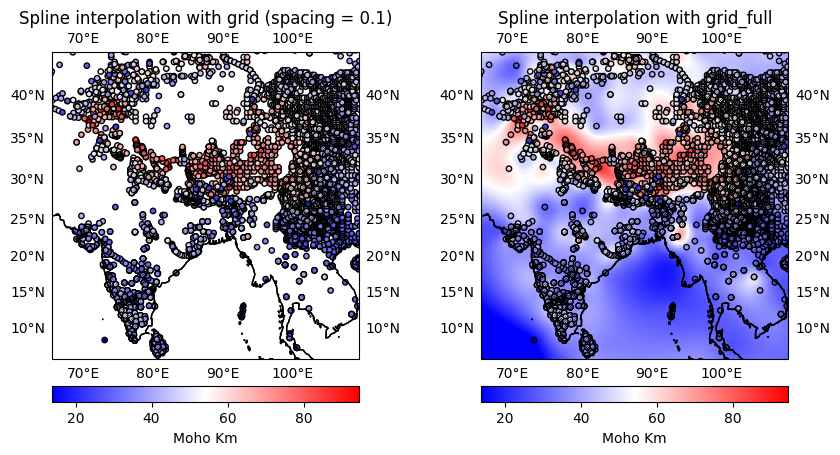

In [17]:
fig, axes = plt.subplots(
    1, 2, figsize=(9.5, 7), subplot_kw=dict(projection=ccrs.Mercator())
)
crs = ccrs.PlateCarree()
region = [
        data_moho.longitude.min(), data_moho.longitude.max(), 
        data_moho.latitude.min(), data_moho.latitude.max()
    ]
fig.subplots_adjust(wspace=0.4)  # Increase space (default is 0.2)
for ax in axes:
    ax.set_extent(region, crs=crs)  # Set region for both subplots
    ax.coastlines()  # Add coastlines
    #ax.add_feature(cfeature.BORDERS, linestyle=':')  # Add national boundaries
    gl = ax.gridlines(draw_labels=True, crs=crs, alpha=0)

# Plot Moho data in the first subplot
ax = axes[0]
ax.set_title(f"Spline interpolation with grid (spacing = {spacing})")
maxabs = np.nanmax(np.abs(moho))  
minabs = np.nanmin(np.abs(moho))
pc = grid.moho.plot.pcolormesh(
    ax=ax,
    cmap="bwr",
    vmin=minabs,
    vmax=maxabs,
    transform=crs,
    add_colorbar=False,
    add_labels=False,
)
plt.colorbar(pc, ax=ax, orientation="horizontal", pad=0.05).set_label("Moho Km")
ax.plot(data.Long, data.Lat, ".k", markersize=0.1, transform=crs)
ax.coastlines()

# Add scatter plot for Moho depths
sc = ax.scatter(
    eq_info.Long,  # Ensure correct coordinate for longitude
    eq_info.Lat,   # Ensure correct coordinate for latitude
    c=eq_info.Moho_km,  # Moho depth values for coloring
    cmap='bwr',  # Color map
    s=15,  # Adjust size of the points
    edgecolors='black',  # Black edges for points
    vmin=minabs,  # Set vmin consistent with pcolormesh
    vmax=maxabs,  # Set vmax consistent with pcolormesh
    transform=crs  # Use Cartopy's coordinate system
)

# Print eq_info to check data
#print(eq_info)

# Add colorbar for the Moho depth
#cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=0.05)
#cbar.set_label("RF Moho Depth [Km]")

ax = axes[1]
ax.set_title("Spline interpolation with grid_full")
maxabs = np.nanmax(np.abs(moho))  
minabs = np.nanmin(np.abs(moho))
pc = grid_full.moho.plot.pcolormesh(
    ax=ax,
    cmap="bwr",
    vmin=minabs,
    vmax=maxabs,
    transform=crs,
    add_colorbar=False,
    add_labels=False,
)
plt.colorbar(pc, ax=ax, orientation="horizontal", pad=0.05).set_label("Moho Km")
ax.plot(data.Long, data.Lat, ".k", markersize=0.1, transform=crs)
ax.coastlines()

# Add scatter plot for Moho depths
sc = ax.scatter(
    eq_info.Long,  # Ensure correct coordinate for longitude
    eq_info.Lat,   # Ensure correct coordinate for latitude
    c=eq_info.Moho_km,  # Moho depth values for coloring
    cmap='bwr',  # Color map
    s=15,  # Adjust size of the points
    edgecolors='black',  # Black edges for points
    vmin=minabs,  # Set vmin consistent with pcolormesh
    vmax=maxabs,  # Set vmax consistent with pcolormesh
    transform=crs  # Use Cartopy's coordinate system
)

#plt.colorbar(pc, ax=ax, orientation="horizontal", pad=0.05).set_label("Km")
ax.plot(data.Long, data.Lat, ".k", markersize=0.1, transform=crs)
ax.coastlines()
plt.show()

In [18]:
t=grid.moho.as_numpy()
p=grid_full.moho.as_numpy()

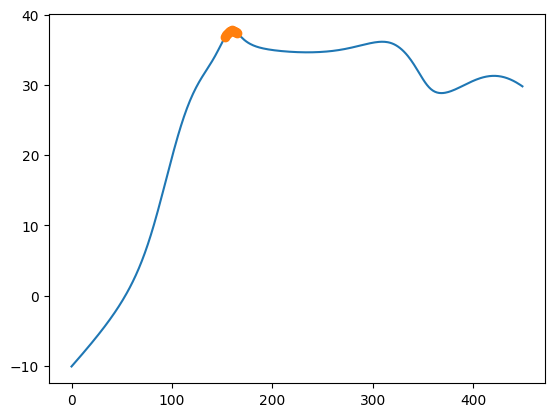

In [19]:
plt.plot(p.values[10])
plt.plot(t.values[10],'o')

# Weight Distribution

## Standard Deviation of Spline wrt RF

In [20]:
# Extract coordinates and RF Moho values
rf_lat = data_eq.Lat.values
rf_lon = data_eq.Long.values
rf_moho = data_eq.Moho_km.values

# Interpolate the spline Moho values at RF locations
spline_moho = spline.predict(projection(rf_lon, rf_lat))


# Compute the overall standard deviation (STD) of the residuals (RF Moho - Spline Moho)
overall_std = np.std(rf_moho - spline_moho)

# Compute pointwise variance (squared error) for each data point
pointwise_variance = abs((rf_moho - spline_moho)) #** 2

# Create a new DataFrame with latitude, longitude, RF Moho, Spline Moho, and pointwise variance
df = pd.DataFrame({
    "latitude": rf_lat,
    "longitude": rf_lon,
    "rf_moho": rf_moho,
    "spline_moho": spline_moho,
    "err_moho": pointwise_variance  # Variance (squared error)
})

# Print summary
print(df)
print("\nOverall STD of Spline relative to RF Moho:", overall_std)
df.to_csv("spline_data.csv", index=False)

      latitude  longitude  rf_moho  spline_moho   err_moho
0        36.43      94.87     49.5    58.038950   8.538950
1        36.43      94.87     48.0    58.038950  10.038950
2        36.81      92.95     49.0    50.311227   1.311227
3        37.02      91.74     57.0    57.558870   0.558870
4        32.25      91.70     74.0    68.773899   5.226101
...        ...        ...      ...          ...        ...
8298     21.33     103.91     34.0    32.751893   1.248107
8299     17.42      78.55     33.0    32.713087   0.286913
8300      8.28      73.06     14.0    14.230154   0.230154
8301     11.66      92.74     19.0    27.387797   8.387797
8302      7.27      80.70     40.0    37.999876   2.000124

[8303 rows x 5 columns]

Overall STD of Spline relative to RF Moho: 4.323674607776202


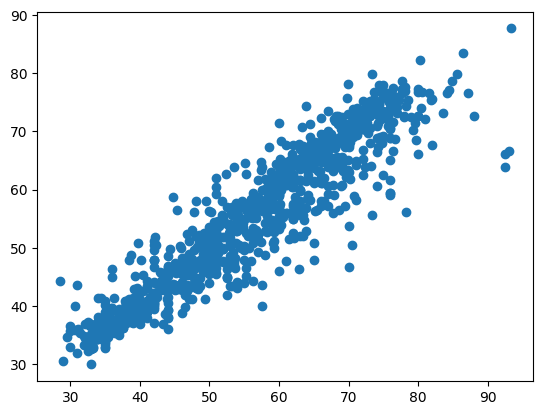

In [21]:
plt.scatter(x=data_eq['Moho_km'][0:1000],y=spline_moho[0:1000])

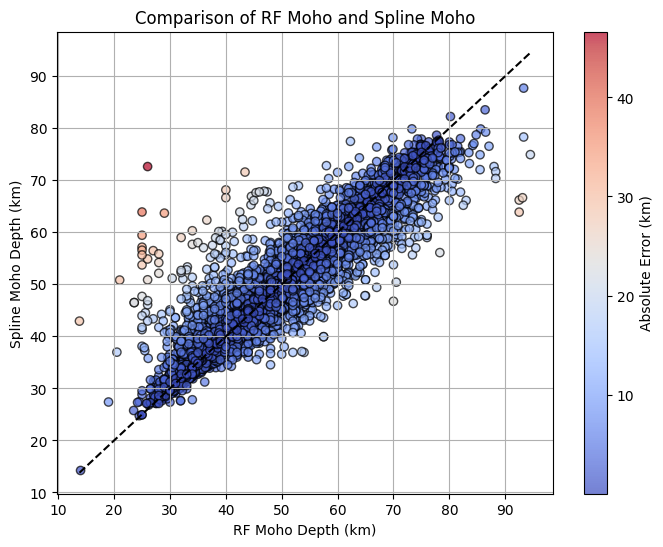

In [22]:
plt.figure(figsize=(8, 6))
plt.scatter(df["rf_moho"], df["spline_moho"], c=df["err_moho"], cmap="coolwarm", edgecolor="k", alpha=0.7)
plt.plot([df["rf_moho"].min(), df["rf_moho"].max()], [df["rf_moho"].min(), df["rf_moho"].max()], 'k--')  # 1:1 line
plt.colorbar(label="Absolute Error (km)")
plt.xlabel("RF Moho Depth (km)")
plt.ylabel("Spline Moho Depth (km)")
plt.title("Comparison of RF Moho and Spline Moho")
plt.grid(True)
plt.show()


In [23]:
data_moho.head

<bound method NDFrame.head of       longitude  latitude   Moho
0          65.5      44.5  38.31
1          66.5      44.5  39.22
2          67.5      44.5  40.41
3          68.5      44.5  41.65
4          69.5      44.5  42.31
...         ...       ...    ...
1795      105.5       5.5  29.93
1796      106.5       5.5  29.93
1797      107.5       5.5  29.93
1798      108.5       5.5  29.90
1799      109.5       5.5  28.87

[1800 rows x 3 columns]>

In [24]:
# Create a KDTree for RF locations
rf_tree = cKDTree(list(zip(df.longitude, df.latitude)))

# Assign RF Moho directly where RF exists (100% weight to RF)
df["weighted_moho"] = df["rf_moho"]

# Create 1°x1° bins and check which bins have no RF data
df["lat_bin"] = (df["latitude"] // 1) * 1
df["lon_bin"] = (df["longitude"] // 1) * 1

data_moho["lat_bin"] = (data_moho["latitude"] // 1) * 1
data_moho["lon_bin"] = (data_moho["longitude"] // 1) * 1

rf_bins = set(zip(df["lat_bin"], df["lon_bin"]))
all_bins = set(zip(data_moho["lat_bin"], data_moho["lon_bin"]))

# Identify bins with no RF data
missing_rf_bins = all_bins - rf_bins
df_no_rf = data_moho[data_moho[["lat_bin", "lon_bin"]].apply(tuple, axis=1).isin(missing_rf_bins)].copy()

# Assign Crust1.0 Moho first
df_no_rf["weighted_moho"] = df_no_rf["Moho"]


# Find the nearest RF node for each location without RF
_, nearest_rf_idx = rf_tree.query(list(zip(df_no_rf.longitude, df_no_rf.latitude)))

# Get **precomputed** spline_moho from the nearest RF node
df_no_rf["nearest_rf_spline_moho"] = df.spline_moho.iloc[nearest_rf_idx].values

# Predict spline Moho for each missing RF location using the global spline
df_no_rf["nearest_rf_spline_moho"] = spline.predict(
    projection(df_no_rf.longitude, df_no_rf.latitude)
)

# Compute x and y using the **precomputed nearest RF spline Moho**
x = df_no_rf["nearest_rf_spline_moho"] - df_no_rf["weighted_moho"]
y = abs(x)

# Apply updated weighting logic
df_no_rf["weighted_moho"] = np.where(
    y < overall_std,  
    df_no_rf["nearest_rf_spline_moho"],  # If error is small, use nearest RF spline Moho
    0.4 * df_no_rf["nearest_rf_spline_moho"] + 0.6 * df_no_rf["weighted_moho"]  # Otherwise, use weighted combination
)

# Combine both datasets
df_final = pd.concat([df, df_no_rf], ignore_index=True)

# Save to CSV
df_final.to_csv("weighted_moho.csv", index=False)

# Print summary
print(df_final)


      latitude  longitude  rf_moho  spline_moho   err_moho  weighted_moho  \
0        36.43      94.87     49.5    58.038950   8.538950      49.500000   
1        36.43      94.87     48.0    58.038950  10.038950      48.000000   
2        36.81      92.95     49.0    50.311227   1.311227      49.000000   
3        37.02      91.74     57.0    57.558870   0.558870      57.000000   
4        32.25      91.70     74.0    68.773899   5.226101      74.000000   
...        ...        ...      ...          ...        ...            ...   
9300      5.50     105.50      NaN          NaN        NaN      30.967142   
9301      5.50     106.50      NaN          NaN        NaN      31.151855   
9302      5.50     107.50      NaN          NaN        NaN      31.083682   
9303      5.50     108.50      NaN          NaN        NaN      30.708889   
9304      5.50     109.50      NaN          NaN        NaN      30.026184   

      lat_bin  lon_bin   Moho  nearest_rf_spline_moho  
0        36.0     9

In [25]:
df_final['weighted_moho']

0       49.500000
1       48.000000
2       49.000000
3       57.000000
4       74.000000
          ...    
9300    30.967142
9301    31.151855
9302    31.083682
9303    30.708889
9304    30.026184
Name: weighted_moho, Length: 9305, dtype: float64

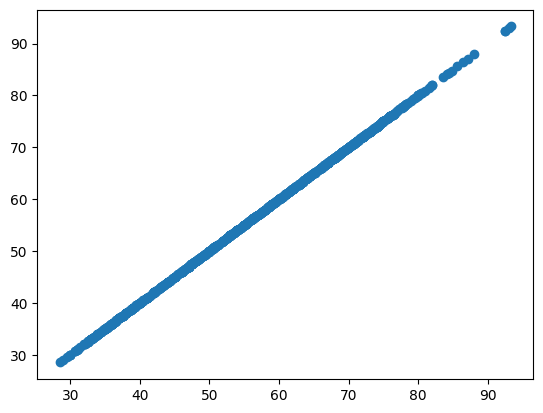

In [26]:
plt.scatter(x=data_eq['Moho_km'][0:1000],y=df_final['weighted_moho'][0:1000])

No. of times Crust1.0 falls under close proximity of RFs: 590
343
9305
      latitude  longitude  weighted_moho
0         44.5       65.5      42.519361
1         44.5       66.5      42.512944
2         44.5       67.5      42.622685
13        44.5       78.5      45.516172
14        44.5       79.5      45.857494
...        ...        ...            ...
1784       5.5       94.5      26.966682
1785       5.5       95.5      32.767083
1787       5.5       97.5      32.486882
1788       5.5       98.5      31.499351
1789       5.5       99.5      30.882195

[590 rows x 3 columns]


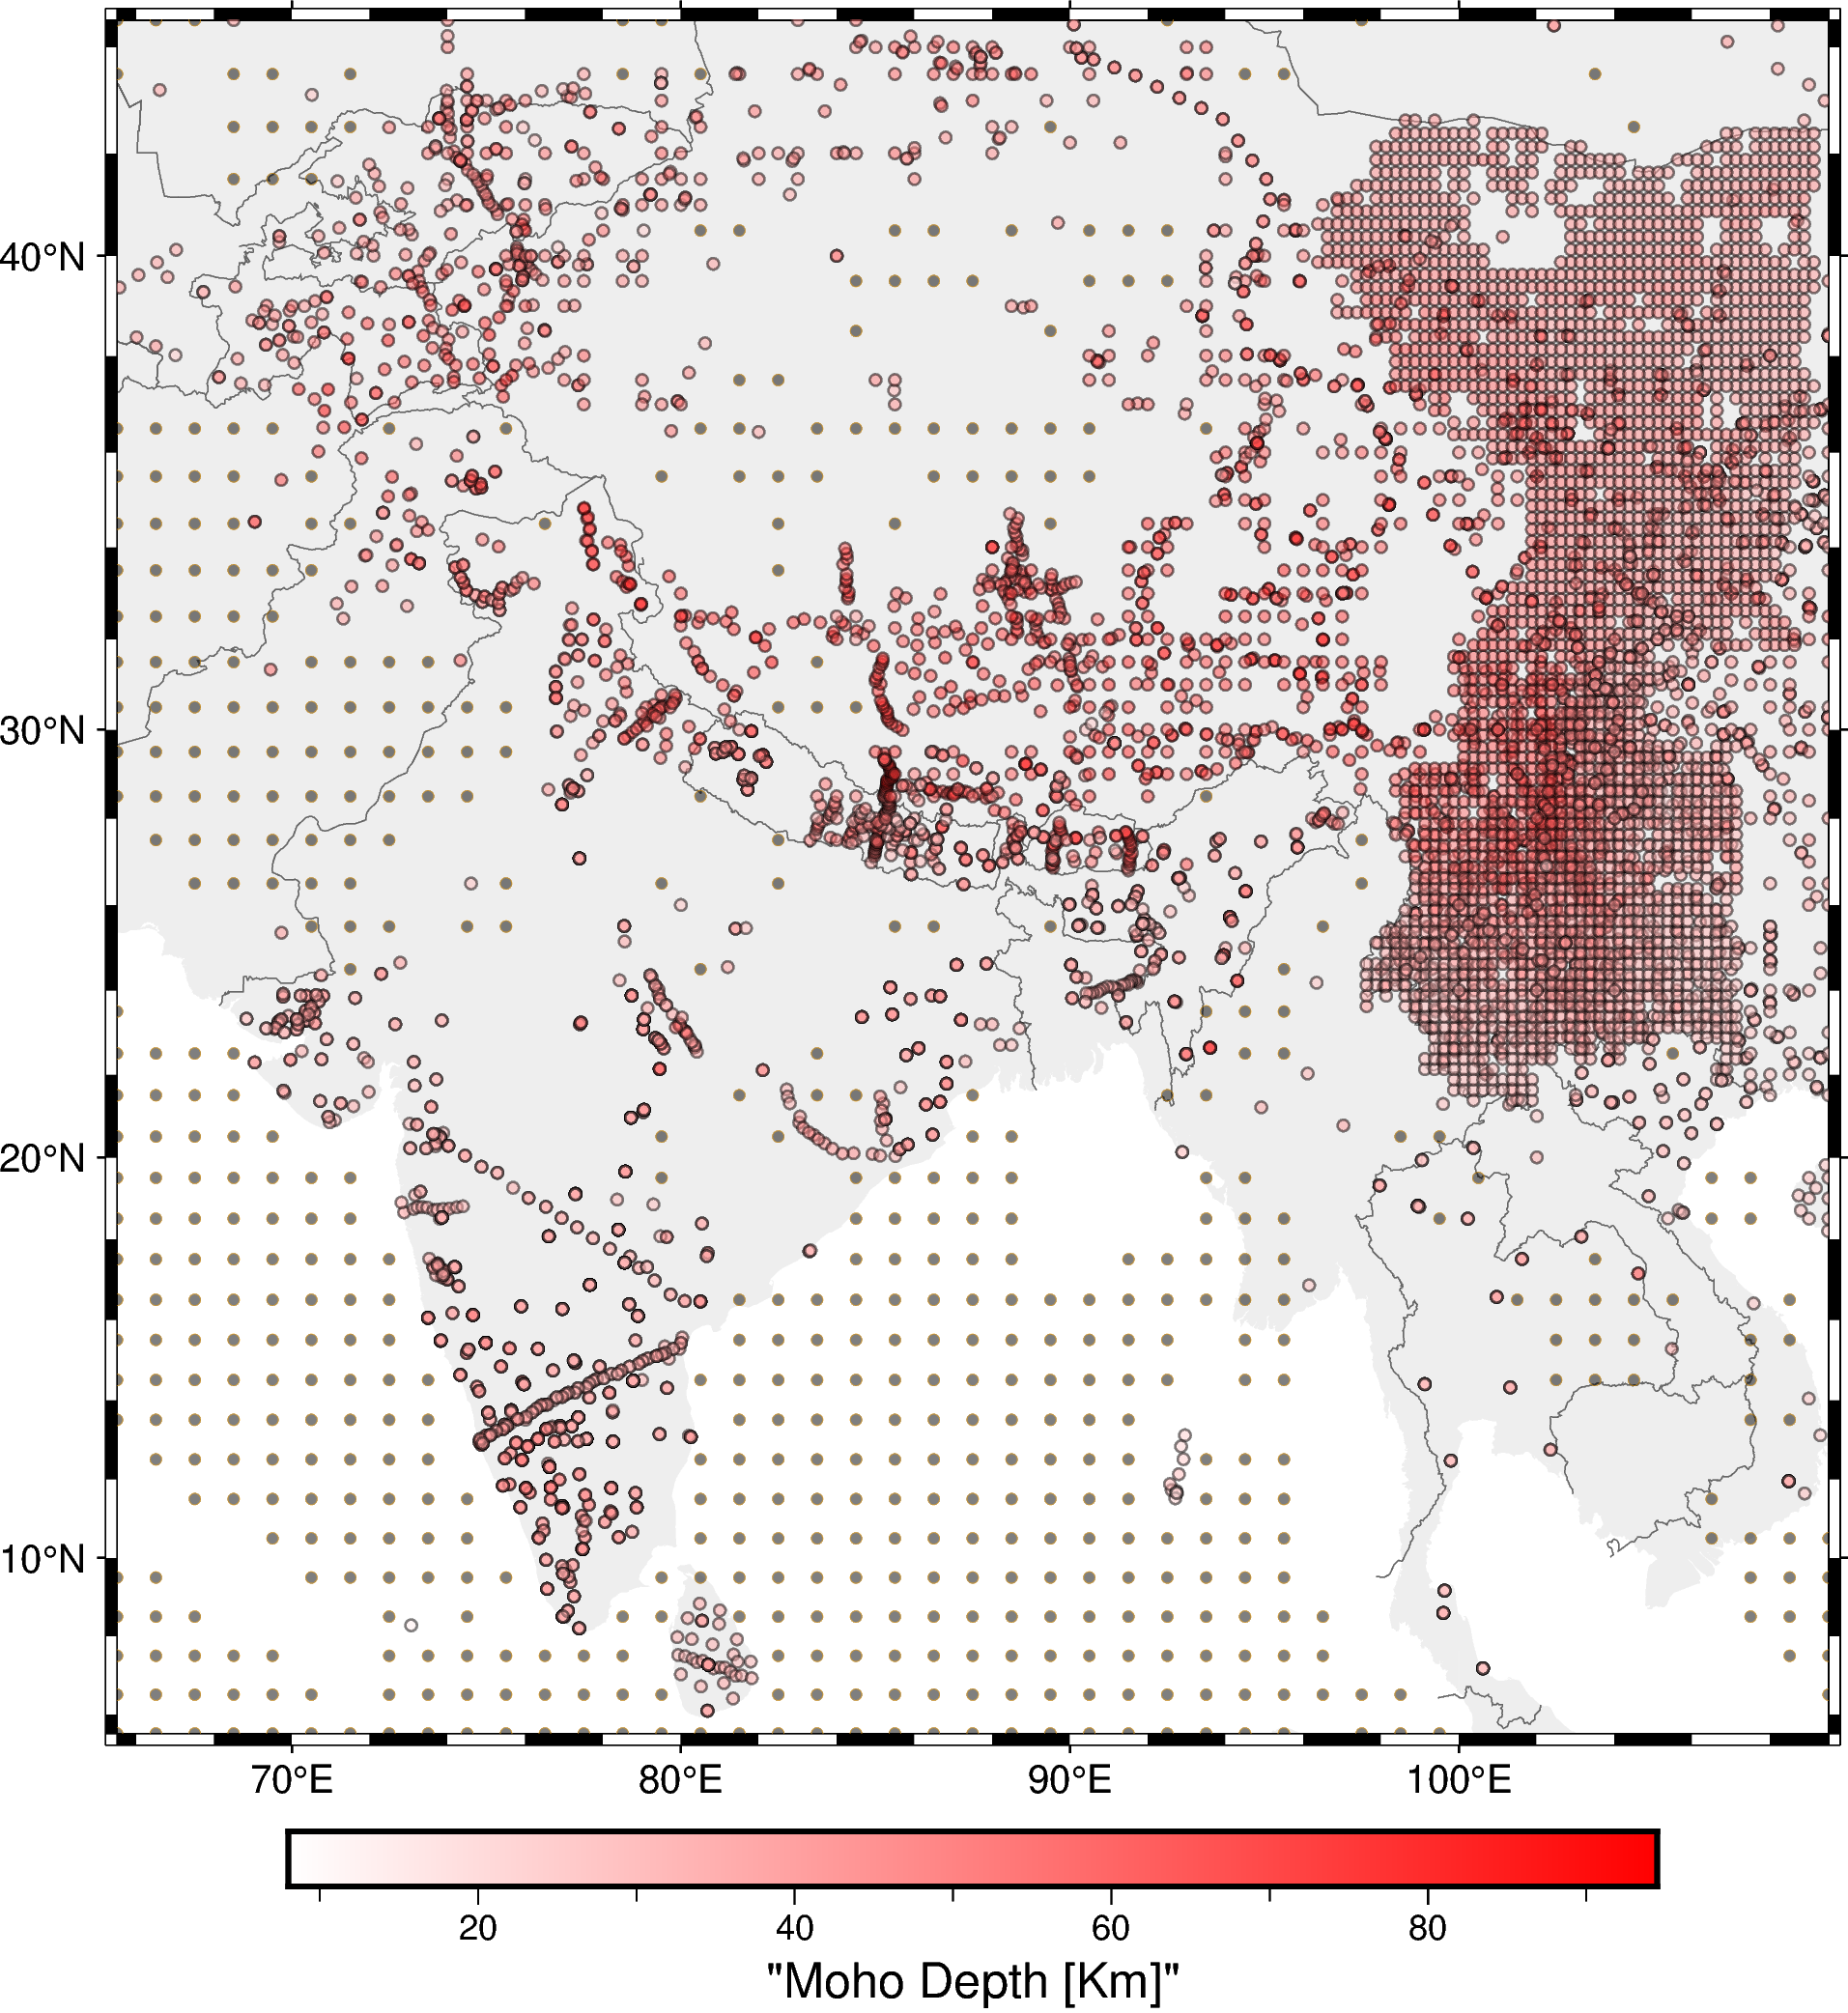

In [30]:
# Count occurrences where y < overall_std
count_close_proximity = (y > overall_std).sum()
c = (x < 0).sum()
# Print the result
print(f"No. of times Crust1.0 falls under close proximity of RFs: {count_close_proximity}")
print (c)
print(len(df_final))

# Filter the dataframe where x < 0
#df_condition = df_no_rf[x < 0][["latitude", "longitude", "weighted_moho"]]
df_condition = df_no_rf[y > overall_std][["latitude", "longitude", "weighted_moho"]]
# Display the filtered dataframe
print(df_condition)

# Start a figure
fig = pygmt.Figure()
# Add a basemap with the data region, Mercator projection, default frame
# and ticks, color in the continents, and display national borders
fig.coast(
    region=region, projection="M15c", frame="af",
    land="#eeeeee", borders="1/#666666", area_thresh=1e4,
)
# Create a colormap for the Moho Depth
pygmt.makecpt(
    cmap="polar+h",
    series=[data_eq_all.Moho_km.min(), data_eq_all.Moho_km.max()],
    #series = [data.iloc[:, 5].min(), data.iloc[:, 5].max()],
)
fig.plot(
    x=data_eq.Long,
    y=data_eq.Lat,
    fill=data_eq.Moho_km,
    style="c0.1c",
    cmap=True,
    pen="0.5p,black",transparency=50
)
# Plot colored points for the velocities
fig.plot(
    x=df_condition.longitude,
    y=df_condition.latitude,
    #fill=data_eq_all.Moho_km,
    style="c0.1c",
    cmap=True,
    pen="0.1p,orange",transparency=50
)
# Add a colorbar with automatic frame and ticks and a label
fig.colorbar(frame='af+l"Moho Depth [Km]"')
fig.show()
#fig.savefig("/home/amitava/Downloads/test.png", dpi=300)
fig.savefig(r"C:\Users\DELL\Downloads\test.png", dpi=300)

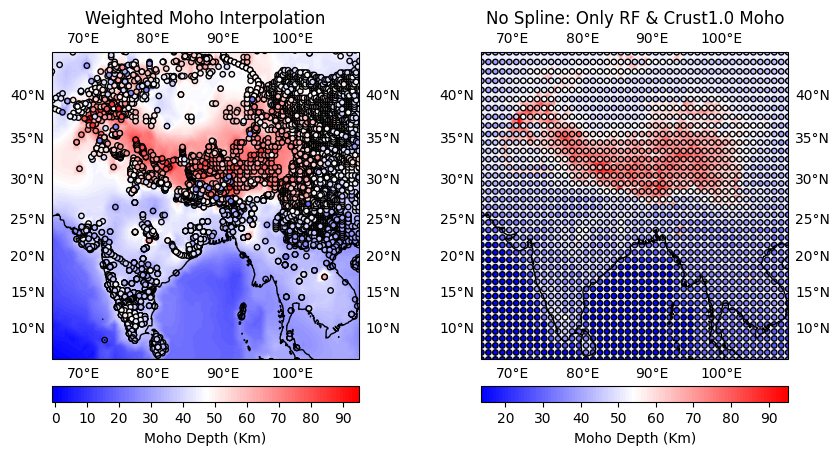

In [28]:
fig, axes = plt.subplots(
    1, 2, figsize=(9.5, 7), subplot_kw=dict(projection=ccrs.Mercator())
)
crs = ccrs.PlateCarree()
region = [
    data_moho.longitude.min(), data_moho.longitude.max(),
    data_moho.latitude.min(), data_moho.latitude.max()
]

fig.subplots_adjust(wspace=0.4)  # Increase space (default is 0.2)

for ax in axes:
    ax.set_extent(region, crs=crs)
    ax.coastlines()
    #ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.gridlines(draw_labels=True, crs=crs, alpha=0)

# -------- Subplot 1: Weighted Moho --------
ax = axes[0]
ax.set_title("Weighted Moho Interpolation")
maxabs = np.nanmax(np.abs(df_final.weighted_moho))
minabs = np.nanmin(np.abs(df_final.weighted_moho))

pc = ax.tricontourf(
    df_final.longitude, df_final.latitude, df_final.weighted_moho,
    cmap="bwr", levels=100, vmin=minabs, vmax=maxabs, transform=crs
)

#plt.colorbar(pc, ax=ax, orientation="horizontal", pad=0.05).set_label("Moho Depth (Km)")
# For Weighted Moho Interpolation
cbar = plt.colorbar(pc, ax=ax, orientation="horizontal", pad=0.05)
cbar.set_label("Moho Depth (Km)")
cbar.locator = MaxNLocator(integer=True)
cbar.update_ticks()

# Scatter plot for RF Moho points
sc = ax.scatter(
    eq_info.Long, eq_info.Lat, c=eq_info.Moho_km,
    cmap='bwr', s=15, edgecolors='black',
    vmin=minabs, vmax=maxabs, transform=crs
)

# -------- Subplot 2: Unweighted Moho (RF + Crust1.0) --------
ax = axes[1]
ax.set_title("No Spline: Only RF & Crust1.0 Moho")
maxabs_unweighted = np.nanmax(np.abs(df.rf_moho))
minabs_unweighted = np.nanmin(np.abs(df.rf_moho))

pc = ax.tricontourf(
    df.longitude, df.latitude, df.rf_moho,
    cmap="bwr", levels=100, vmin=minabs_unweighted, vmax=maxabs_unweighted, transform=crs
)

#plt.colorbar(pc, ax=ax, orientation="horizontal", pad=0.05).set_label("Moho Depth (Km)")
# For Weighted Moho Interpolation
cbar = plt.colorbar(pc, ax=ax, orientation="horizontal", pad=0.05)
cbar.set_label("Moho Depth (Km)")
cbar.locator = MaxNLocator(integer=True)
cbar.update_ticks()

# Scatter plot for Crust1.0 Moho values
ax.scatter(
    data_moho.longitude, data_moho.latitude, c=data_moho.Moho,
    cmap='bwr', s=15, edgecolors='black',
    vmin=minabs_unweighted, vmax=maxabs_unweighted, transform=crs
)

plt.show()
